# Series de Tiempo
## Trabajo Final - Parte Bitcoin Árbol de Decisión

**Presentado por:**
- Miguel Ángel Quintero
- Natalia Castilla
- Juan Pablo Saenz

In [84]:
import pandas as pd
import matplotlib.pylab as plt
import numpy as np
import statsmodels.api as sm

import scipy as sp
import scipy.stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

import datetime as dt

Para este modelo el preprocesamiento solo consistirá en el análisis de la serie diaria para ver la autocorrelación. Para un mayor analisis ver el notebook *ARIMA Bitcoin*

In [83]:
df = pd.read_csv('bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv')
df["Timestamp"] = pd.to_datetime(df["Timestamp"],unit='s')

# 1. Preprocesamiento
Debido a que si se trabaja con datos mensuales quedarán pocos datos para la validación, el test y el entrenamiento, se utilizarán la media de los datos diarios.

In [85]:
df_bitcoin = df.copy()
df_bitcoin = df_bitcoin.dropna()
df_bitcoin = df_bitcoin.drop(['Volume_(BTC)','Volume_(Currency)','Weighted_Price'],axis=1)
df_bitcoin = df_bitcoin.set_index('Timestamp')
df_bitcoin = df_bitcoin.resample('D').mean().dropna()

print(df_bitcoin.index)

DatetimeIndex(['2011-12-31', '2012-01-01', '2012-01-02', '2012-01-03',
               '2012-01-04', '2012-01-05', '2012-01-06', '2012-01-07',
               '2012-01-08', '2012-01-09',
               ...
               '2021-03-22', '2021-03-23', '2021-03-24', '2021-03-25',
               '2021-03-26', '2021-03-27', '2021-03-28', '2021-03-29',
               '2021-03-30', '2021-03-31'],
              dtype='datetime64[ns]', name='Timestamp', length=3376, freq=None)


Y se diferencia sobre la serie original para observar las estructuras de correlación de ambas series.

In [86]:
dif_df=df_bitcoin['Close'].diff(periods=1).dropna()
print('Prueba de Dickey-Fuller: ', adfuller(dif_df)[1])

Prueba de Dickey-Fuller:  3.982736484406059e-15


Además, la serie diferenciada según la prueba de Dickey-Fuller nos indica que esta es estacionaria. Por lo cual, las gráficas de autocorrelación serán:

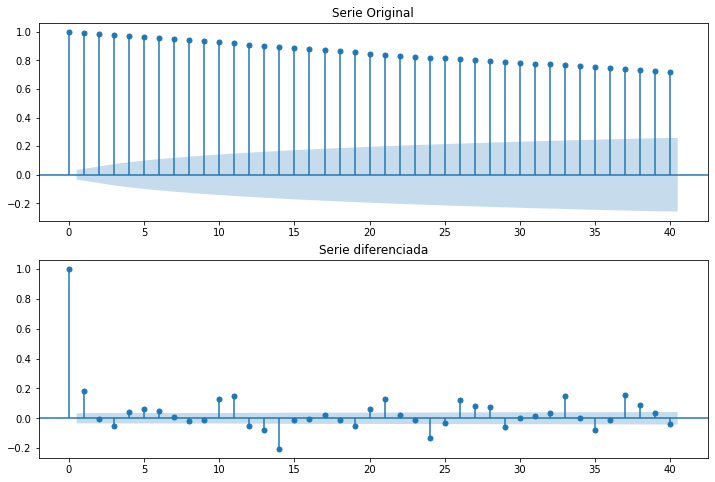

In [88]:
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(211)
plot_acf(df_bitcoin.Close,lags=40,title='Serie Original',ax=ax1)

ax2 = fig.add_subplot(212)
plot_acf(dif_df.dropna(),lags=40,title='Serie diferenciada',ax=ax2)

plt.show()

En el caso de las autocorrelaciones de la serie diferenciada, parece que son significativaos el 1, 4, 5, 6 y 10 lag.

# 2. Árboles de decisión

Para el modelo de árboles de decisión, como se observó en el preprocesamiento, se trabajará con los primeros los retardos significativos encontrados en la sección anterior teniendo la estructura de correlación observada.

In [128]:
df_arbol = pd.DataFrame()
h= [1,4,5,6,10]
for i in h: #cambiar dependiendo de los rezagos
    df_arbol['t-'+str(i)] = df_bitcoin['Close'].shift(i)
df_arbol['t'] = df_bitcoin['Close']
df_arbol= df_arbol.dropna(axis=0)
df_arbol

,t-1,t-4,t-5,t-6,t-10,t
Timestamp,,,,,,
2012-01-10,6.581667,6.445000,6.286190,5.223333,4.482500,6.603000
2012-01-11,6.603000,6.800000,6.445000,6.286190,4.806667,7.121875
2012-01-12,7.121875,6.950000,6.800000,6.445000,5.000000,7.062500
2012-01-13,7.062500,6.581667,6.950000,6.800000,5.252500,6.960313
2012-01-14,6.960313,6.603000,6.581667,6.950000,5.223333,6.410000
...,...,...,...,...,...,...
2021-03-27,53243.124454,54706.291854,56789.432469,57316.312566,56161.324448,55195.415367
2021-03-28,55195.415367,55126.809462,54706.291854,56789.432469,58475.458908,55835.012863
2021-03-29,55835.012863,52125.759256,55126.809462,54706.291854,58286.613419,56915.629993


## 2.1. Hiperparametro

In [133]:
df_split = df_arbol.values
X1= df_split[:, 0:-1] 
y1 =df_split[:,-1]
X_train_full, X_test, y_train_full, y_test=train_test_split(X1,y1,test_size=0.1, train_size=0.9,shuffle=False)
X_train, X_val, y_train, y_val=train_test_split(X_train_full,y_train_full,test_size=0.1, train_size=0.9,shuffle=False)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(2726,)
(303,)
(337,)


En total se tiene que:

- 337 datos para prueba
- 303 datos para validación
- 2726 datos para entrenamiento.

In [134]:
params = []
for d in range(1,10):
    decision_tree = DecisionTreeRegressor(max_depth=d)
    decision_tree.fit(X_train, y_train)
    params.append([d,decision_tree.score(X_train, y_train),decision_tree.score(X_val,y_val)])

df_params = pd.DataFrame(params,columns=['depth','score_train','score_val'])
df_params.sort_values(by='score_train',ascending=False)

,depth,score_train,score_val
8,9,0.999627,0.897785
7,8,0.999352,0.916537
6,7,0.998993,0.922006
5,6,0.998367,0.918382
4,5,0.997201,0.936062
3,4,0.994479,0.890578
2,3,0.984856,0.706663
1,2,0.947135,-0.303990
0,1,0.780428,-0.148134


En este caso manteniendo un equilibrio entre el score_train y el score_val, se obtiene que la mejor profundidad corresponde a 9, entonces este será el valor de este hyperparametro.

Ahora, entrenando el modelo con este parametro para mirar los resultados sobre los datos de prueba.

In [135]:
decision_tree= DecisionTreeRegressor(max_depth=9)

decision_tree.fit(X_train_full, y_train_full)

print(decision_tree.score(X_train_full, y_train_full))
print(decision_tree.score(X_test,y_test))  

0.9993825240964861
0.016844814627968052


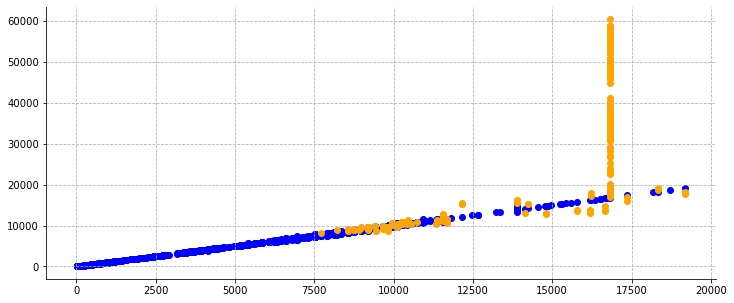

In [151]:
train_prediction = decision_tree.predict(X_train_full)
test_prediction = decision_tree.predict(X_test)

fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(111)
ax1.scatter(train_prediction, y_train_full, label='train',color='blue')
ax1.scatter(test_prediction, y_test, label='test',color='orange')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
plt.grid(ls='--',alpha=7)
plt.show()

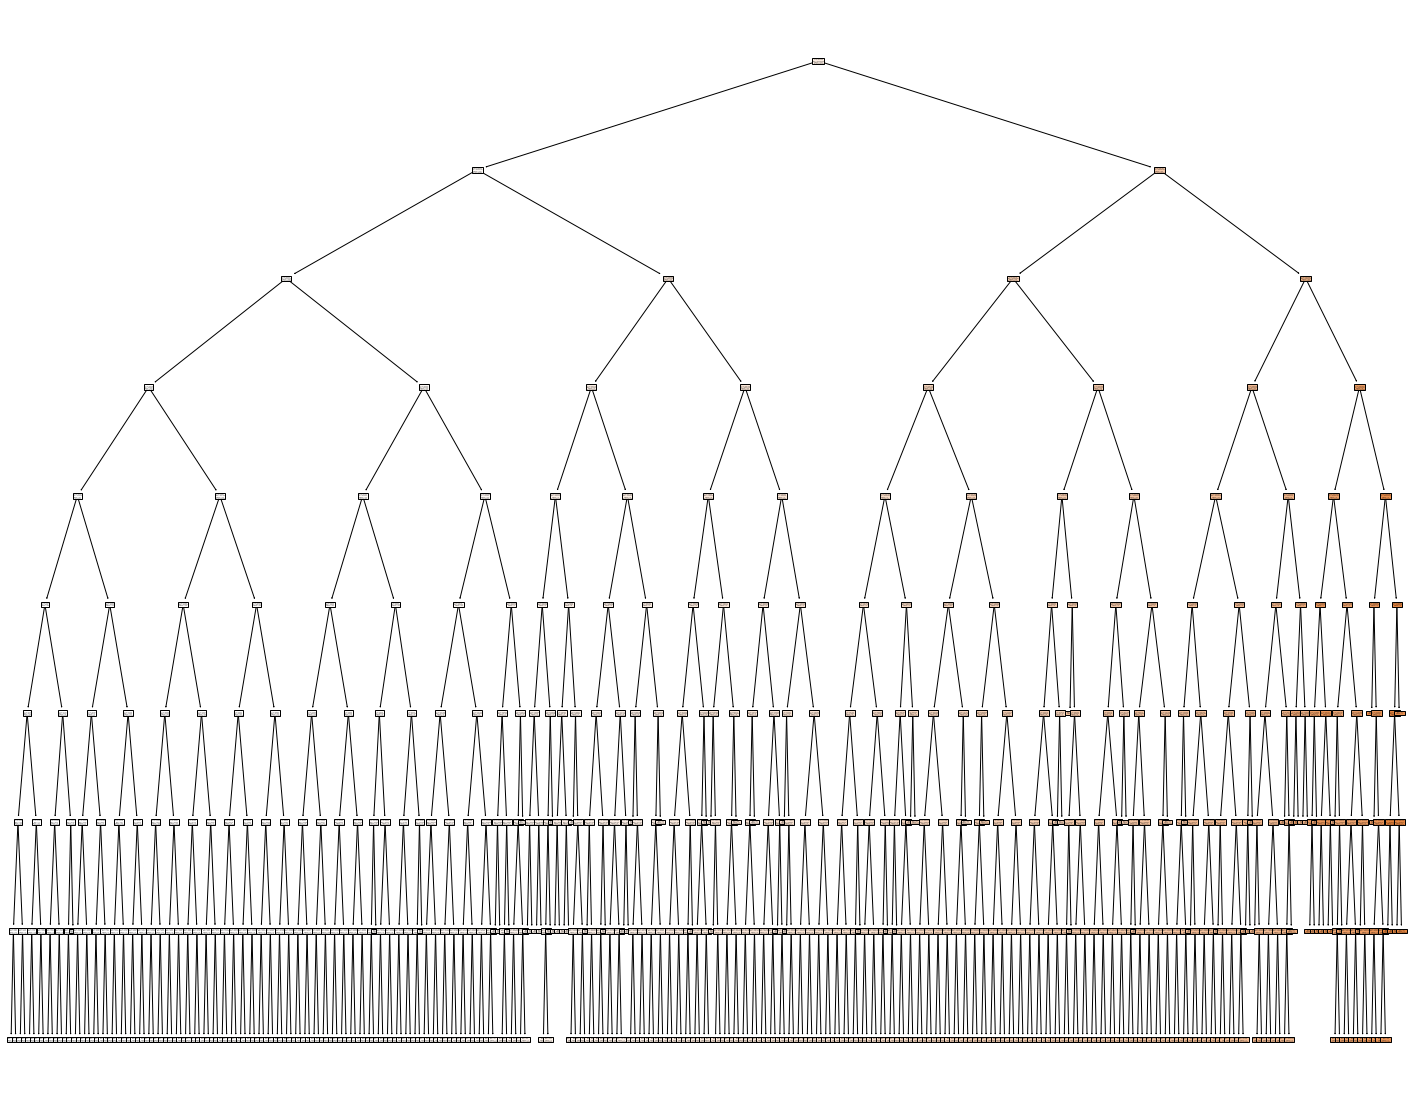

In [140]:
from sklearn import tree
listacaract=list(df_arbol.columns.values)
respuesta=listacaract.pop()

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(decision_tree,
 feature_names=listacaract, 
 class_names=respuesta,
 filled=True)

## 2.2. Predicción

Aunque por los resultados anteriores parece ser que el poder de predicción de este modelo sobre la serie no será muy bueno, se procederá a realizar dicha predicción para observar los resultados.

In [141]:
targetjoint=np.concatenate((y_train_full,y_test))
predictionjoint=np.concatenate((train_prediction,test_prediction))
indicetrian_test=df_arbol.index
indicetrain=indicetrian_test[0:521]
indicetest=indicetrian_test[521:579]
d = {'observado': targetjoint, 'Predicción': predictionjoint}
ObsvsPred=pd.DataFrame(data=d,index=indicetrian_test)
ObsvsPred.head(10)

,observado,Predicción
Timestamp,,
2012-01-10,6.603000,6.652425
2012-01-11,7.121875,6.652425
2012-01-12,7.062500,6.652425
2012-01-13,6.960313,6.652425
2012-01-14,6.410000,6.652425
2012-01-15,7.150000,6.652425
2012-01-16,6.714286,6.652425
2012-01-17,6.141667,6.652425
2012-01-18,6.244722,5.697948


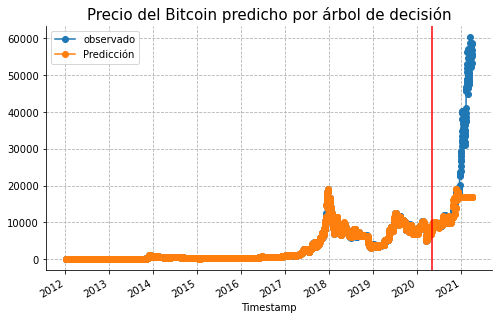

In [156]:
fig = plt.figure(figsize=(8,5))
ax1 = fig.add_subplot(111)
ObsvsPred.plot(marker="o",ax=ax1)
ax1.axvline(x=df_arbol.index[3030],color='red')
ax1.set_title("Precio del Bitcoin predicho por árbol de decisión", size=15)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
plt.grid(ls='--',alpha=7)
plt.savefig('predicción Árbol.png')
plt.show()

## 2.3. Error cuadratico medico
Para evaluar el desempeño del modelo y compararlo con los otros modelos realizados, se procede a calcular el error cuadratico medio.

In [158]:
print('El RMSE es: ', np.sqrt(np.mean(np.power(ObsvsPred["Predicción"] -ObsvsPred['observado'],2))))

El RMSE es:  4907.514250041478
